In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x +5

In [3]:
f(3.0)

20.0

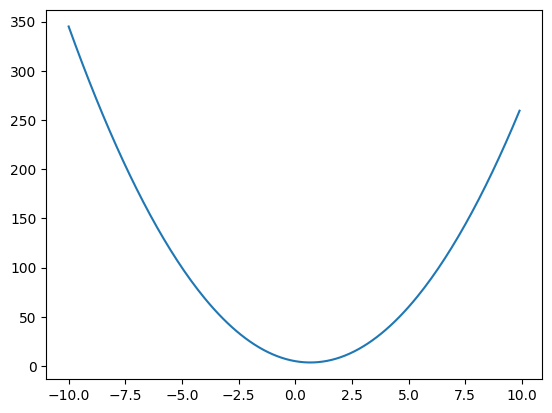

In [4]:
xs = np.arange(-10, 10, 0.1)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000000000000001
x = 2/3
(f(x+h) - f(x))/h

0.0

Derivative of F(x) = ax + b

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label ,n.data, n.grad, ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [15]:
# We need to create tissue to connect the neurons together
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = list(_children)
    self._op = _op
    self.label = label

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    # c = Value( a+b, (a, b), '+')

    # The inputs will always be pointing to the same nodes
    # When the values of the nodes changes, the values of the inputs will change
    # You only have to call this function when you want to backprop
    def _backward_add(child1=self, child2=other, root=out):
      child1.grad += 1.0 * root.grad
      child2.grad += 1.0 * root.grad
    out._backward = _backward_add
    
    return out
  def __pow__(self, other):
    out = Value(self.data ** other, (self,), f'**{other}')
    # c = Value( a**2, (a, ), '**2')
    
    def _backward_pow(child=self, root=out):
      child.grad += other * child.data**(other-1) * root.grad
    out._backward = _backward_pow
    
    return out
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    # c = Value( a*b, (a, b), '*')
    
    def _backward_mul(child1=self, child2=other, root=out):
      child1.grad += child2.data * root.grad
      child2.grad += child1.data * root.grad
    out._backward = _backward_mul
      
    return out
  
  def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward_ReLu(child=self, root=out):
            child.grad += (root.data > 0) * root.grad
        out._backward = _backward_ReLu

        return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

  def __neg__(self): # -self
        return self * -1

  def __radd__(self, other): # other + self
      return self + other

  def __sub__(self, other): # self - other
      return self + (-other)

  def __rsub__(self, other): # other - self
      return other + (-self)

  def __rmul__(self, other): # other * self
      return self * other

  def __truediv__(self, other): # self / other
      return self * other**-1

  def __rtruediv__(self, other): # other / self
      return other * self**-1

  def __repr__(self):
      return f"Value(data={self.data}, grad={self.grad})"

In [16]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
bb = Value(6.8813735870195432, label='bb')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + bb; n.label = 'n'
o = n.tanh(); o.label = 'o'

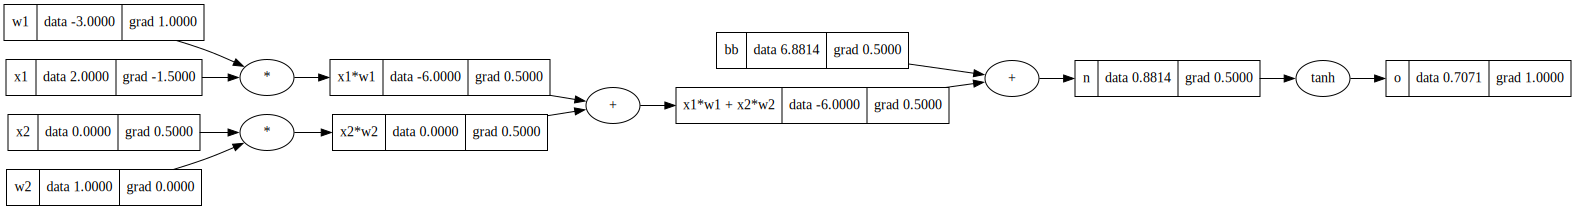

In [19]:
draw_dot(o)

In [18]:
# # print label of children of 
o.backward()

In [20]:
import torch

In [21]:
# Just as in micrograd, pytorch has a tensor class with the same attributes

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [24]:
torch.Tensor([[1,2,3],[4,5,6]]).double().dtype

torch.float64